In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm as WN
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D 
types=torch.float64
torch.set_default_dtype(types)

In [2]:
class PDE_with_boundary():
    """Class for a PDE with Neumann a Dirichlet conditions"""
    def __init__(self, eqn_config):
        self.dim=eqn_config["dim"]
        self.total_time=eqn_config["total_time"]
        self.Ndis=eqn_config["Ndis"]
        self.delta_t=self.total_time/self.Ndis
        self.sqrt_delta_t = np.sqrt(self.delta_t)
        self.x_init = torch.zeros(self.dim,requires_grad=False)
        self.sigma = np.sqrt(2.0)
        self.lambd = 1.0
        self.model=ResNetLikeDGM(3,1)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.01,weight_decay=0.00001)
        self.scheduler = StepLR(self.optimizer,step_size=5000,gamma=0.5)
        
        
    def interior_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.random.uniform(size=(num_sample,self.dim))
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def dirichlet_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.stack((np.ones(num_sample),np.random.uniform(size=num_sample)*0.2),axis=1)
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def neumann_sample(self,num_sample):
        Ns=int(num_sample/4)
        iz=np.stack((np.zeros(Ns),np.random.uniform(size=Ns)),axis=1)
        niz=np.repeat([[1.0,0.0]],Ns,0)
        up=np.stack((np.random.uniform(size=Ns),np.ones(Ns)),axis=1)
        nup=np.repeat([[0.0,1.0]],Ns,0)
        down=np.stack((np.random.uniform(size=Ns),np.zeros(Ns)),axis=1)
        ndown=np.repeat([[0.0,-1.0]],Ns,0)
        der=np.stack((np.ones(Ns),0.2+np.random.uniform(size=Ns)*0.8),axis=1)
        nder=np.repeat([[-1.0,0.0]],Ns,0)
        x=np.concatenate((iz,up,down,der))
        t=np.random.uniform(low=0,high=self.total_time,size=[x.shape[0],1])
        return torch.tensor(np.hstack((t,x)),requires_grad=True),torch.tensor(np.concatenate((niz,nup,ndown,nder)))
    
    def terminal_sample(self,num_sample):
        T=np.ones(shape=[num_sample,1])*self.total_time
        x=np.random.uniform(size=[num_sample,self.dim])
        return torch.tensor(np.hstack((T,x)),requires_grad=True)
        
    def loss(self,interior_sample,neumann_sample,dirichlet_sample,terminal_sample):
        
        V=self.model(interior_sample)
        dV=torch.autograd.grad(V,interior_sample, grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_t=dV[:,0]
        V_x=dV[:,1:]
        V_xx=torch.autograd.grad(dV,interior_sample,grad_outputs=torch.ones_like(dV),retain_graph=True,create_graph=True,only_inputs=True)[0][:,1:]
        diff_V=self.Lv(interior_sample, V_t,V_x,V_xx)
        L1=torch.mean(torch.square(diff_V))
        
        x_neumann,n_neumann=neumann_sample
        Vn=self.model(x_neumann)
        dVn=torch.autograd.grad(Vn,x_neumann, grad_outputs=torch.ones_like(Vn),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_x=dVn[:,1:]
        normaldVn=torch.sum(V_x*n_neumann,axis=1)
        L2=torch.mean(torch.square(normaldVn-self.h_n(x_neumann)))
        
        Vd=self.model(dirichlet_sample)
        L3=torch.mean(torch.square(Vd-self.h_d(dirichlet_sample)))
        
        Vter=self.model(terminal_sample)
        L4=torch.mean(torch.square(Vter-self.g_Tf(terminal_sample)))
        
        return L1+L2+L3+L4
    
    def h_n(self,x):
        """Neumann boundary condition"""
        return torch.zeros(x.shape[0])
    
    def h_d(self,x):
        """Dirichlet boundary condition"""
        return -torch.ones(x.shape[0])
    
    def g_Tf(self,x):
        """Terminal condition"""
        return torch.zeros(x.shape[0])
        
    def Lv(self, x, V_t,V_x,V_xx):
        return V_t+torch.sum(V_xx,axis=1)-self.lambd*torch.sum(V_x*V_x,axis=1)
    
    def train(self):
        start_time = time.time()
        training_history = []
        interior_valid = self.interior_sample(512)
        neumann_valid= self.neumann_sample(512)
        dirichlet_valid=self.dirichlet_sample(512)
        terminal_valid=self.terminal_sample(512)

        # begin sgd iteration
        for step in range(20001):
            #print(step)
            interior = self.interior_sample(512)
            neumann= self.neumann_sample(512)
            dirichlet=self.dirichlet_sample(512)
            terminal=self.terminal_sample(512)
            loss=self.loss(interior,neumann,dirichlet,terminal)
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            for _ in range(10):
                
                self.optimizer.step()
                self.scheduler.step() 
            
            if step % 200==0:
                loss = self.loss(interior_valid,neumann_valid,dirichlet_valid,terminal_valid).detach().numpy()
                #y_init = self.y_0.detach().numpy()[0]
                elapsed_time = time.time() - start_time
                training_history.append([step, loss, elapsed_time])
                print("Epoch ",step," time ", elapsed_time," loss ", loss)

        return np.array(training_history)
    def save_model(self,file_name):
        torch.save(self.model.state_dict(), file_name)
    def load_model(self,file_name):
        self.model.load_state_dict(torch.load(file_name))

In [3]:

sigma = torch.tanh

class DGMCell(nn.Module):
    def __init__(self, d, M, growing, weight_norm):
        super().__init__()
        wn = WN if weight_norm else lambda x: x

        self.Uz = wn(nn.Linear(d, M, bias=False))
        self.Ug = wn(nn.Linear(d, M, bias=False))
        self.Ur = wn(nn.Linear(d, M, bias=False))
        self.Uh = wn(nn.Linear(d, M, bias=False))

        self.Wz = wn(nn.Linear(M, M))
        self.Wg = wn(nn.Linear(M, M))
        self.Wr = wn(nn.Linear(M, M))
        self.Wh = wn(nn.Linear(M, M))

        self.A = (lambda x: x) if growing else sigma

    def forward(self, SX):
        S, X = SX
        Z = sigma(self.Uz(X) + self.Wz(S))
        G = sigma(self.Ug(X) + self.Wg(S))
        R = sigma(self.Ur(X) + self.Wr(S))
        H = self.A(self.Uh(X) + self.Wh(S*R))
        S = (1-G)*H + Z*S

        return S, X


def _set_convert(flag):
    if flag: return lambda X: X[0]
    return lambda X: torch.stack(X, -1)


class ResNetLikeDGM(nn.Module):
    """
    DGM algorithm from https://arxiv.org/pdf/1708.07469.pdf
    Args:
    -----
    d_in and d_out- input and ouput dimensions of the problem
    M - layers' width
    L - recurrency depth
    """
    def __init__(
            self, d_in, d_out, M=50, L=3,
            growing=False, as_array=True, weight_norm=False):
        super().__init__()
        wn = WN if weight_norm else lambda x: x
        self.W0 = wn(nn.Linear(d_in, M))
        self.W1 = wn(nn.Linear(M, d_out))
        self._convert = _set_convert(as_array)

        self.layers = []
        for l in range(L):
            self.layers.append(DGMCell(d_in, M, growing, weight_norm))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, *X):
        X = self._convert(X)
        S = sigma(self.W0(X))
        S,_ = self.layers((S, X))
        return self.W1(S).squeeze_(-1)


In [4]:
pde=PDE_with_boundary({"dim":2,"total_time":1.0,"Ndis":20})

In [5]:
#pde.train()
pde.load_model('u_salida.pth')

In [6]:
def proyectar_adentro(X):
    x=X[0]
    y=X[1]
    if x<0.0:
        x=0.0
    elif x>1.0:
        x=1.0
    if y<0:
        y=0.0
    elif y>1.0:
        y=1.0
    return x,y
    
        
def simular_trayectoria(model,X0,dt):
    t=0.0
    x=[X0[0]]
    y=[X0[1]]
    while t<=1:
        pos=torch.tensor([t,x[-1],y[-1]],requires_grad=True)
        u=model(pos)
        alpha=torch.autograd.grad(u,pos)[0]
        xnew=x[-1]+2*alpha[0]*dt+np.sqrt(2)*np.random.normal(loc=0.0,scale=np.sqrt(dt))
        ynew=y[-1]+2*alpha[1]*dt+np.sqrt(2)*np.random.normal(loc=0.0,scale=np.sqrt(dt))
        xn,yn=proyectar_adentro([xnew,ynew])
        x.append(xn)
        y.append(yn)
        t+=dt
    return x,y        

In [7]:
x,y=simular_trayectoria(pde.model,[0.1,0.9],0.01)

(-0.05, 1.05, -0.05, 1.05)

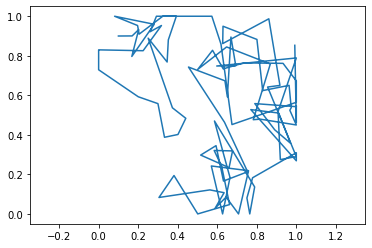

In [8]:
plt.plot(x,y)
plt.axis('equal')

In [9]:
pde.model(torch.tensor([0.1,0.1,0.1]))

tensor(-1.2901, grad_fn=<SqueezeBackward4>)

Text(0.5, 0, 'Z Label')

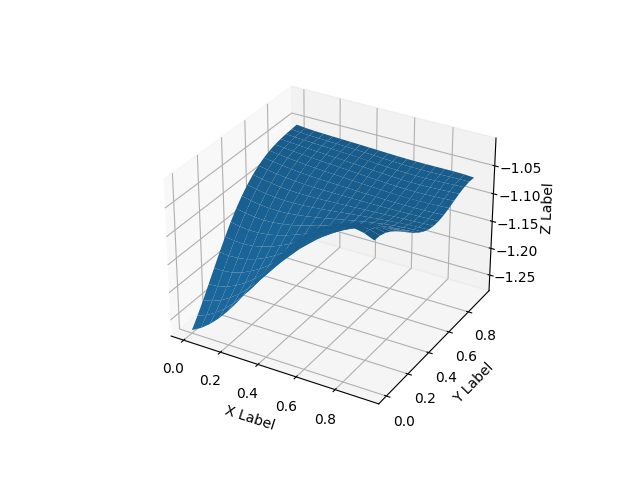

In [11]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 1.0, 0.05)
X, Y = np.meshgrid(x, y)
times=0.0*np.ones(np.ravel(X).shape[0])
tes=torch.tensor(np.stack((times,np.ravel(X), np.ravel(Y)),axis=1))
zs =pde.model(tes).detach().numpy()
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')